In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # Sigmoid function for logistic link

def simulate_zip_with_covariates(n, beta_pois, beta_zero, seed=None):
    if seed is not None:
        np.random.seed(seed)

    X1 = np.random.normal(0, 1, n)
    X2 = np.random.normal(0, 1, n)

    X = np.column_stack((np.ones(n), X1, X2))

    logit_zi = X @ beta_zero
    prob_zero = expit(logit_zi)  # Apply logistic link

    is_zero = np.random.binomial(1, prob_zero)

    log_mu = X @ beta_pois
    mu = np.exp(log_mu)  # Apply log link

    y_pois = np.random.poisson(mu)

    y = np.where(is_zero == 1, 0, y_pois)
    return pd.DataFrame({
        'X1': X1,
        'X2': X2,
        'mu_pois': mu,
        'p_zero': prob_zero,
        'y': y
    })

beta_pois = np.array([0.5, 0.7, -0.3])     # Intercept and slopes for Poisson
beta_zero = np.array([-1.0, 0.5, 0.8])     # Intercept and slopes for zero inflation
df_zip = simulate_zip_with_covariates(n=1000, beta_pois=beta_pois, beta_zero=beta_zero, seed=42)

print(df_zip.head())

         X1        X2   mu_pois    p_zero  y
0  0.496714  0.926178  1.767996  0.497325  1
1 -0.138264  1.909417  0.843994  0.612635  0
2  0.647689 -1.398568  3.946986  0.142460  0
3  1.523030  0.562969  4.043983  0.552775  6
4 -0.234153 -0.650643  1.701118  0.162793  1


In [14]:
from statsmodels.tools.tools import add_constant

X = df_zip[[ "X1", "X2" ]].values
X = add_constant(X)
y = df_zip[[ "y" ]].values

from statsmodels.discrete.count_model import ZeroInflatedPoisson

model = ZeroInflatedPoisson(endog=y,
                            exog=X,
                            exog_infl=X
                           )


modelzip = model.fit()
modelzip.summary()

Optimization terminated successfully.
         Current function value: 1.388434
         Iterations: 17
         Function evaluations: 19
         Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                  500
Model:             ZeroInflatedPoisson   Df Residuals:                      497
Method:                            MLE   Df Model:                            2
Date:                 Thu, 17 Apr 2025   Pseudo R-squ.:                  0.1840
Time:                         22:49:59   Log-Likelihood:                -694.22
converged:                        True   LL-Null:                       -850.80
Covariance Type:             nonrobust   LLR p-value:                 9.905e-69
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.8019      0.156     -5.129      0.000      -1.108      -0.495
inflate_x1        0.3706      0.156      2.377      0.017       0.065       0.676
inflate_x2        0.9271      0.155      5.970      0.000       0.623       1.231
const             0.5260      0.052     10.103      0.000       0.424       0.628
x1                0.6971      0.044     16.010      0.000       0.612       0.782
x2               -0.2429      0.046     -5.279      0.000      -0.333      -0.153
=================================================================================
"""

In [474]:

from typing import Any, Optional

import torch
from torch import Tensor
from torch.distributions import Laplace

from gpytorch.constraints import Interval, Positive
from gpytorch.distributions import base_distributions
from gpytorch.priors import Prior
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

class ZeroInflatedPoissonLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        self.raw_pi = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        
        mu_constraint = Positive()
        pi_constraint = Interval(0, 1)
        
        self.register_constraint("raw_mu", mu_constraint)
        self.register_constraint("raw_pi", pi_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)
        
    @property
    def pi(self) -> Tensor:
        return self.raw_pi_constraint.transform(self.raw_pi)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    @pi.setter
    def pi(self, value: Tensor) -> None:
        self._set_pi(value)

    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))
        
    def _set_pi(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_pi)
        self.initialize(raw_pi=self.raw_pi_constraint.inverse_transform(value))

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.ZeroInflatedPoisson:
        rate = torch.exp(function_samples)  * self.mu
        pi = torch.sigmoid(function_samples * self.pi)
        return base_distributions.ZeroInflatedPoisson(rate=rate, gate=pi)

In [475]:
class PoissonLikelihood(_OneDimensionalLikelihood):
    def __init__(
        self,
        batch_shape: torch.Size = torch.Size([])
    ) -> None:
        super().__init__()

        self.raw_mu = torch.nn.Parameter(torch.ones(*batch_shape, 1))
        
        mu_constraint = Positive()
        
        self.register_constraint("raw_mu", mu_constraint)

    @property
    def mu(self) -> Tensor:
        return self.raw_mu_constraint.transform(self.raw_mu)

    @mu.setter
    def mu(self, value: Tensor) -> None:
        self._set_mu(value)
        
    def _set_mu(self, value: Tensor) -> None:
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_mu)
        self.initialize(raw_mu=self.raw_mu_constraint.inverse_transform(value))

    def forward(self, function_samples: Tensor, *args: Any, **kwargs: Any) -> base_distributions.Poisson:
        rate = torch.exp(function_samples) * self.mu
        return base_distributions.Poisson(rate=rate)

In [476]:
import urllib.request
import os
from scipy.io import loadmat
from math import floor
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, DeltaVariationalDistribution, MeanFieldVariationalDistribution
from gpytorch.variational import VariationalStrategy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

N = 500
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
y = base_distributions.Poisson(rate=torch.exp(X)).sample().double().cuda().flatten()

In [484]:
import math

class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LargeFeatureExtractor, self).__init__()
        self.add_module('linear2', torch.nn.Linear(1, 500))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(500, 50))
        self.add_module('relu3', torch.nn.ReLU())
        self.add_module('linear4', torch.nn.Linear(50, 1))


class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(),
            # outputscale_prior=gpytorch.priors.SmoothedBoxPrior(y.min(), y.max())
        )
        
        # self.feature_extractor = feature_extractor
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # projected_x = self.feature_extractor(x)
        # projected_x = self.scale_to_bounds(projected_x)  
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

feature_extractor = LargeFeatureExtractor()
inducing_points = X.clone()
M = 30
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=feature_extractor).double()
likelihood = ZeroInflatedPoissonLikelihood().double()
likelihood = PoissonLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
likelihood.initialize(mu=200)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 1000
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

100
1.4120832659838245
200
1.4115113567265667
300
1.4111028401698733
400
1.4106218205896135
500
1.4100819607749824
600
1.4094938661943166
700
1.4088664362417704
800
1.4082074436721839
900
1.4075238092087818
1000
1.4068217365998594


In [485]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

In [486]:
print(
    gpytorch.metrics.negative_log_predictive_density(preds, y).mean().item(),
    gpytorch.metrics.mean_squared_error(preds, y, squared=True).mean().item(),
    gpytorch.metrics.mean_absolute_error(preds, y).mean().item(),
    gpytorch.metrics.quantile_coverage_error(preds, y, quantile=95).mean().item(),
)

0.002691603193557084 1.5682000840818207 0.9051496599767875 0.004400033038109541


<Axes: xlabel='X1', ylabel='y'>

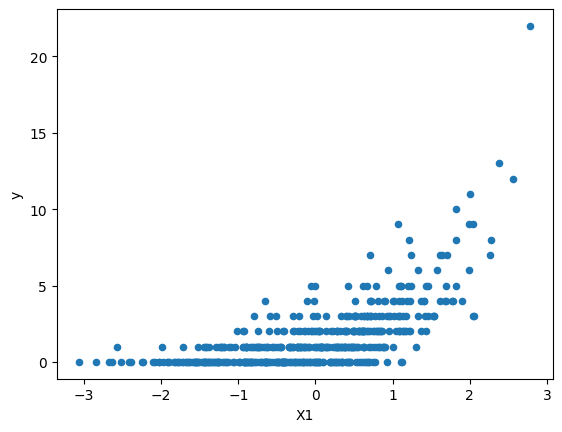

In [482]:
results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

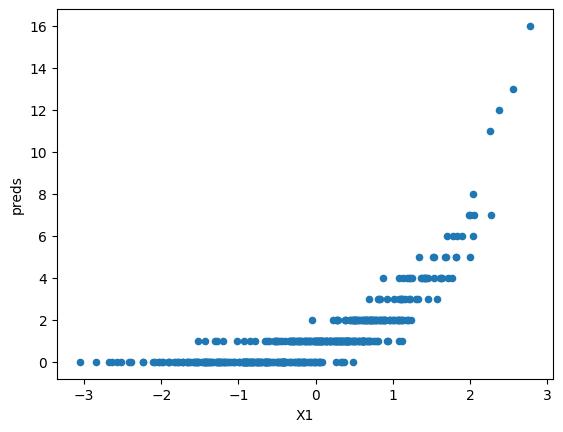

In [483]:
results_df.plot.scatter("X1", "preds")

In [493]:
N = 500
X = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
y = base_distributions.ZeroInflatedPoisson(
    rate=torch.exp(X), gate=torch.tensor([0.25]).double().cuda()
).sample().double().cuda().flatten()

In [504]:
class GPModel(ApproximateGP):
    def __init__(self, inducing_points, feature_extractor):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(),
            # outputscale_prior=gpytorch.priors.SmoothedBoxPrior(y.min(), y.max())
        )
        
        # self.feature_extractor = feature_extractor
        # self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

    def forward(self, x):
        # projected_x = self.feature_extractor(x)
        # projected_x = self.scale_to_bounds(projected_x)  
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


inducing_points = X.clone()
M = 30
inducing_points = torch.normal(mean=0, std =1, size=(1,N)).double().cuda().flatten()
model = GPModel(inducing_points=inducing_points, feature_extractor=feature_extractor).double()
likelihood = ZeroInflatedPoissonLikelihood().double()

if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

model.train()
model.covar_module.base_kernel.initialize(lengthscale=5)
likelihood.train()
likelihood.initialize(mu=200)

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data=y.size(0), lr=0.1)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y.size(0))

n_epochs = 1500
for i in range(1, n_epochs + 1):
    if i % (n_epochs // 10) == 0:
        print(i)
        print(loss.item())
    variational_ngd_optimizer.zero_grad()
    hyperparameter_optimizer.zero_grad()
    output = model(X)
    loss = -mll(output, y)
    loss.backward()
    variational_ngd_optimizer.step()
    hyperparameter_optimizer.step()

150
1.3617782171279758
300
1.3450779990674973
450
1.3308662480955964
600
1.3247809895999292
750
1.3226314176734604
900
1.3214586533339328
1050
1.32048247125383
1200
1.3195351509107898
1350
1.3185770042837341
1500
1.3175976496417101


<Axes: xlabel='X1', ylabel='y'>

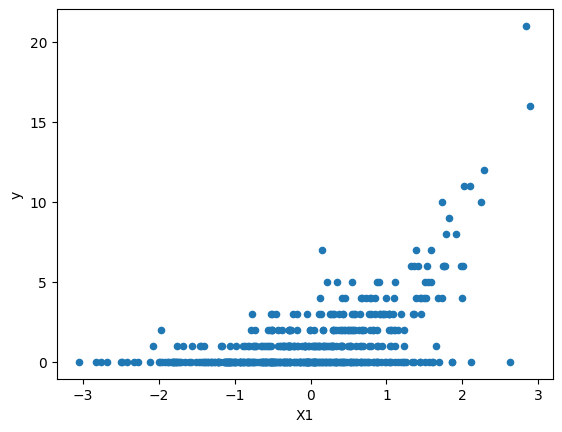

In [505]:
model.eval()
likelihood.eval()
with torch.no_grad():
    preds = likelihood(model(X))

results_df = pd.DataFrame(dict(
    y=y.cpu().numpy(),
    X1=X.cpu().numpy(),
    preds=preds.sample().median(axis=0).values.cpu().numpy()
))

results_df.plot.scatter("X1", "y")

<Axes: xlabel='X1', ylabel='preds'>

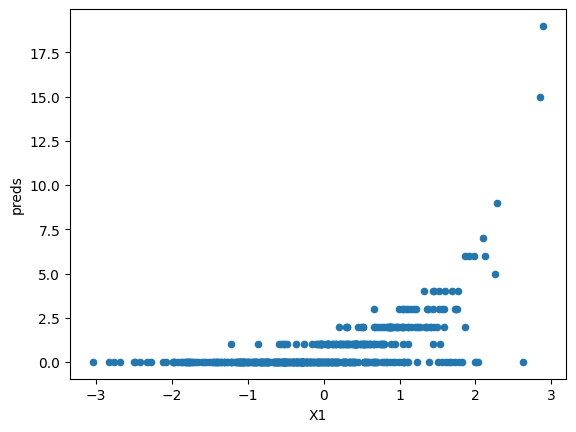

In [506]:
results_df.plot.scatter("X1", "preds")

In [507]:
likelihood.mu

tensor([199.7776], device='cuda:0', dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)

In [508]:
model.covar_module.base_kernel.lengthscale

tensor([[3.8088]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SoftplusBackward0>)